# Predictive Modeling

In the previous notebooks, we developed mathematical models based on mathematical structures: curves, differential equations, and networks to to build explanation, predict future outcomes, or simulate potential scenarios given some data. 

Another area that has gained traction in the recent years due to the rise of data is Machine Learning. It can be used to discover latent patterns in the data and potentially use these patterns to predict unseen data. In this notebook, we will discuss a specific subdomain of Machine Learning which is **Supervised Learning**. In supervised learning, you given labeled data - variables to be used as input (*features*) and their corresponding output variable (*target variable*).

The goal of Supervised learning is to find an optimal function f such that the error between the target value and the predicted value (estimated by f) is minimized.

## Binary Classification

In binary classification, the goal is to predict whether or not, given the features, the outcome is one of two options.

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the Data

To understand the basics of Binary classification in Machine Learning, we will take a look at predicting loan default which is an essential ML application in the financial space. 

We will a dataset described [here](https://www.kaggle.com/datasets/kmldas/loan-default-prediction).

### Data Description
The author of the data describes it as follows:

>This is a synthetic dataset created using actual data from a financial institution. The data has been modified to remove identifiable features and the numbers transformed to ensure they do not link to original source (financial institution).
>
>This is intended to be used for academic purposes for beginners who want to practice financial analytics from a simple financial dataset

### Columns
**Index** - transaction identifier  
**Employeed** - Boolean value that indicates of the person who took the loan is employed (1) or not (0).   
**Bank Balance** - Bank balance of the loan taker  
**Annual Salary** - Annual salary of the loan taker  
**Defaulted?** - target variable (1 if the person defaulted, 0 otherwise)

In [3]:
filepath = 'https://raw.githubusercontent.com/jtitusj/PythonMathMods/main/data/loan_default_prediction.csv'
df = pd.read_csv(filepath)
df.head()

,Index,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0


## Data Cleaning/Preprocessing

First, we need to prepare the data to make it more usable.

Note that the index column is not very useful so we will remove it.

In [14]:
# create a new dataframe for the cleaned table
df_clean = df.copy()

# remove Index column
df_clean.drop(columns='Index', inplace=True)

# drop duplicates
df_clean.drop_duplicates(inplace=True)

In [19]:
print(f'Number of Original Rows: {len(df)}')
print(f'Number of Rows after Dropping Duplicates: {len(df_clean)}')
print(f'Number of Rows Dropped: {len(df) - len(df_clean)}')

Number of Original Rows: 10000
Number of Rows after Dropping Duplicates: 10000
Number of Rows Dropped: 0


In [12]:
# check out info()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Employed       10000 non-null  int64  
 1   Bank Balance   10000 non-null  float64
 2   Annual Salary  10000 non-null  float64
 3   Defaulted?     10000 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 312.6 KB


From above, we see that there are 10,000 entries, of which all columns have complete information. That is, there are **no missing values**.

Moreover, **all columns are of numeric types**.

This means that the data is already clean enough.

## Exploratory Data Analysis (EDA)

### Check Data Distributions

Text(0.5, 0, 'Defaulted?')

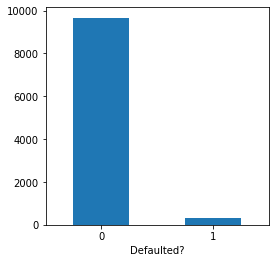

In [29]:
# target variable
ax = df_clean['Defaulted?'].value_counts().plot.bar(rot=0, figsize=(4,4))
ax.set_xlabel('Defaulted?')

We see from the distribution above that the number of individuals that default is lower compared to those that with that. This is referred to as **class imbalance**. This is a common problem in machine learning. Because of this imbalance, we need to be careful when selecting how we measure the effectiveness of our model. We might also want to apply methods to mitigate this imbalance. 

Text(0.5, 0, 'Emmployed?')

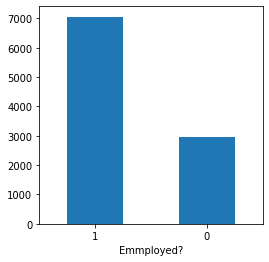

In [30]:
# Employed
ax = df_clean['Employed'].value_counts().plot.bar(rot=0, figsize=(4,4))
ax.set_xlabel('Emmployed?')

We also see that a majority in this data is employed.

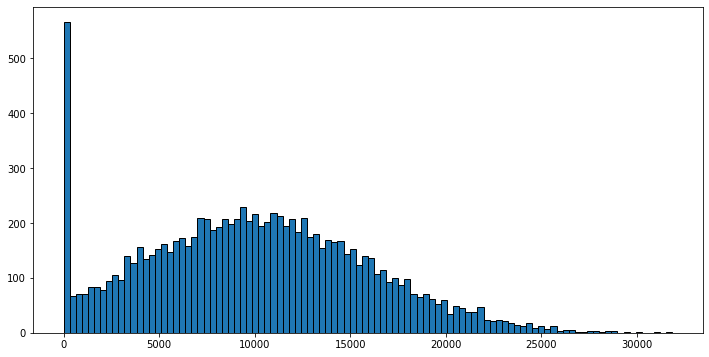

In [38]:
# Bank Balance
df_clean['Bank Balance'].hist(bins=100, grid=False,
                              edgecolor='k', figsize=(12, 6));

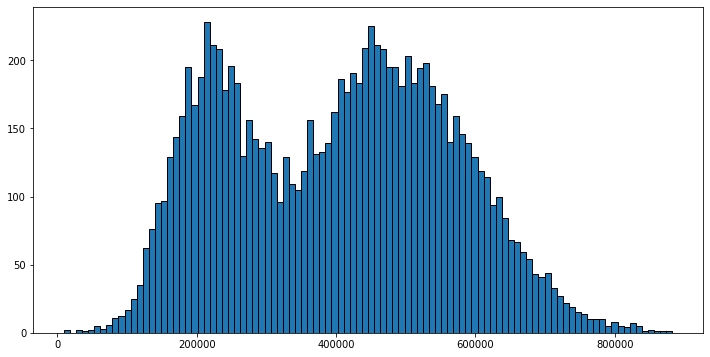

In [39]:
# Bank Balance
df_clean['Annual Salary'].hist(bins=100, grid=False,
                               edgecolor='k', figsize=(12, 6));

### Data Distribution by Outcome

In [48]:
grp = (df_clean.groupby(['Employed', 'Defaulted?']).count().reset_index()
       .pivot(index='Employed', columns='Defaulted?', values='Bank Balance'))
grp

Defaulted?,0,1
Employed,,
0,2817,127
1,6850,206


In [59]:
grp.divide(grp.sum(axis=1), axis=0)

Defaulted?,0,1
Employed,,
0,0.956861,0.043139
1,0.970805,0.029195


The fraction of unemployed individuals who defaulted is higher compared to those who are employed.

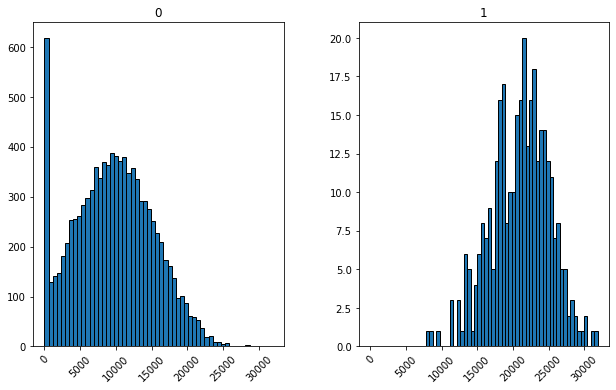

In [71]:
df_clean.hist('Bank Balance', by='Defaulted?', sharex=True, bins=50, rot=45,
              edgecolor='k', figsize=(10, 6));

The bank balance of those who defaulted tend to be lower than the bank balance of those who did not.

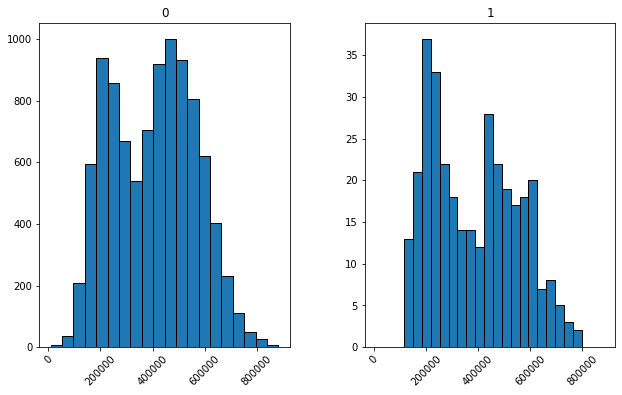

In [74]:
df_clean.hist('Annual Salary', by='Defaulted?', sharex=True, bins=20, rot=45,
              edgecolor='k', figsize=(10, 6));

As for the Annual Salary, both distributions tend to be bimodal.

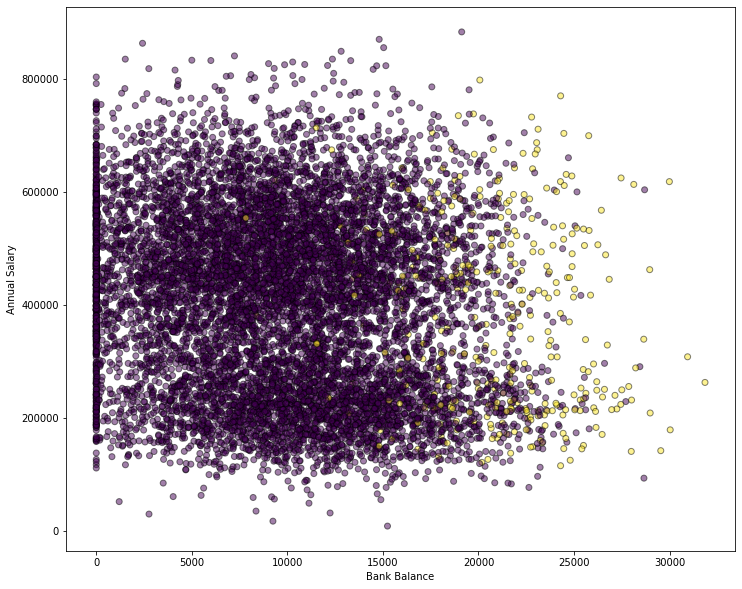

In [89]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(df_clean['Bank Balance'], df_clean['Annual Salary'],
           c=df_clean['Defaulted?'], alpha=0.5, edgecolor='k');
ax.set_xlabel('Bank Balance')
ax.set_ylabel('Annual Salary');

Using the scatter plot above, we see that the `Bank Balance` matter more than the `Annual Salary`.

## Modeling

### Separate data into a training and testing data

The training data will be used for training/fitting the model while the testing data will be set aside until we have finalized the model. The testing data will be used in the end to measure the performance of our models.

In [90]:
from sklearn.model_selection import train_test_split

In [93]:
X_train, X_test, y_train, y_test = train_test_split(df_clean.drop(columns='Defaulted?'),
                                                    df_clean['Defaulted?'],
                                                    test_size=0.2, random_state=42)

In [97]:
print(X_train.head())
print(X_test.head())

      Employed  Bank Balance  Annual Salary
9254         1      12222.84      409246.56
1561         1        746.04      343929.00
1670         1      12560.88      489869.40
6087         1       9164.88      529508.64
6669         0       8367.00      308771.04
      Employed  Bank Balance  Annual Salary
6252         1      17227.92      378085.08
4684         1       9261.48      505668.84
1731         1          0.00      261710.64
4742         1       1362.84      393645.96
4521         1      16297.56      598843.20


In [98]:
print(y_train.head())
print(y_test.head())

9254    0
1561    0
1670    0
6087    0
6669    0
Name: Defaulted?, dtype: int64
6252    0
4684    0
1731    0
4742    0
4521    0
Name: Defaulted?, dtype: int64


### Define Scalers
Scaling is a type of preprocessing which is used to adjust the value of the data. Scalers are used to make the ranges of values across the different features more comparable is it may affect the performance of some models.

In [105]:
from sklearn import preprocessing

In [142]:
scalers = {}

scalers['Standard'] = preprocessing.StandardScaler()
scalers['MinMax'] = preprocessing.MinMaxScaler()
scalers['None'] = None

### Define Classifiers

In [293]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

# metrics and pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, f1_score

# cross validation
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

In [114]:
classifiers = {}

classifiers['LogReg'] = LogisticRegression()
classifiers['DT'] = DecisionTreeClassifier()
classifiers['RF'] = RandomForestClassifier()
classifiers['XGB'] = XGBClassifier(objective="binary:logistic",
                                   use_label_encoder=False,
                                   eval_metric='logloss')

### Create Dataframes for the Scores
Scores here refer to different metrics used to quantify the performance of a model. Different tasks require diffent analysis so selecting a proper metrics requires caution and deep thought.

In [207]:
scores = {}

# create empty dataframes for the different scores
scores['accuracy'] = pd.DataFrame(columns=classifiers.keys(),
                                  index=scalers.keys())
scores['AUC'] = pd.DataFrame(columns=classifiers.keys(),
                             index=scalers.keys())
scores['F1'] = pd.DataFrame(columns=classifiers.keys(),
                            index=scalers.keys())

In [208]:
scores['accuracy']

,LogReg,DT,RF,XGB
Standard,NaN,NaN,NaN,NaN
MinMax,NaN,NaN,NaN,NaN
None,NaN,NaN,NaN,NaN


### Comparing Models and Cross Validation

In [209]:
# separate the training data into a train and validation data
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.2,
                                                    random_state=42)

# Train by iterating over different scalers and models
for key_s, scaler in scalers.items():
    for key_c, classifier in classifiers.items():
        
        if key_s != 'None':
            pipe = make_pipeline(scaler, classifier)
        else:
            pipe = make_pipeline(classifier)
        
        pipe.fit(X_train_, y_train_)
        
        # predictions
        preds = pipe.predict(X_val)
        
        # get performance of the models on the validation set
        scores['accuracy'].loc[key_s, key_c] = pipe.score(X_val, y_val)
        scores['AUC'].loc[key_s, key_c] = roc_auc_score(y_val, preds)
        scores['F1'].loc[key_s, key_c] = f1_score(y_val, preds)

In [210]:
scores['accuracy']

,LogReg,DT,RF,XGB
Standard,0.973125,0.95625,0.96625,0.965625
MinMax,0.97,0.956875,0.966875,0.965625
None,0.965625,0.95625,0.9675,0.965625


In [211]:
scores['AUC']

,LogReg,DT,RF,XGB
Standard,0.628659,0.646735,0.642974,0.660522
MinMax,0.564491,0.647058,0.634361,0.660522
None,0.499677,0.646735,0.634684,0.660522


In [212]:
scores['F1']

,LogReg,DT,RF,XGB
Standard,0.394366,0.326923,0.372093,0.395604
MinMax,0.225806,0.330097,0.361446,0.395604
None,0.0,0.326923,0.365854,0.395604


In [213]:
scores.keys()

dict_keys(['accuracy', 'AUC', 'F1'])

In [214]:
def fit_pipelines(X_train_, X_val, y_train_, y_val, scalers, classifiers, scores):
    
    # Train by iterating over different scalers and models
    for key_s, scaler in scalers.items():
        for key_c, classifier in classifiers.items():

            pipe = make_pipeline(scaler, classifier)
            pipe.fit(X_train_, y_train_)

            # predictions
            preds = pipe.predict(X_val)

            # get performance of the models on the validation set
            scores['accuracy'].loc[key_s, key_c] = pipe.score(X_val, y_val)
            scores['AUC'].loc[key_s, key_c] = roc_auc_score(y_val, preds)
            scores['F1'].loc[key_s, key_c] = f1_score(y_val, preds)
            
    return scores

In [285]:
def compare_models(X, y, classifiers, scores, random_state=42, cross_validate=False):
    
    if not cross_validate:
        # separate the training data into a train and validation data
        X_train_, X_val, y_train_, y_val = train_test_split(X, y,
                                                            test_size=.2,
                                                            random_state=random_state)
        return fit_pipelines(X_train_, X_val, y_train_, y_val, scalers,
                             classifiers, scores)
    
    else:
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
        scores_folds = []
        for train_idx, val_idx in skf.split(X, y):
            X_train_ = X.iloc[train_idx]
            y_train_ = y.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_val = y.iloc[val_idx]
        
            scores_ = fit_pipelines(X_train_, X_val, y_train_, y_val, scalers,
                                    classifiers, scores)
            scores_folds.append(scores_)
            
        scores_folds = {k: [scores_[k] for scores_ in scores_folds]
                        for k in scores.keys()}
        scores_folds = {k: pd.DataFrame(np.array(scores_folds[k]).mean(axis=0),
                                    columns=classifiers.keys(), index=scalers.keys())
                        for k in scores.keys()}
        
        return scores_folds

In [286]:
scores = compare_models(X_train, y_train, classifiers, scores, cross_validate=True)

In [290]:
scores['accuracy']

,LogReg,DT,RF,XGB
Standard,0.98,0.9575,0.9675,0.96625
MinMax,0.97875,0.955,0.96625,0.96625
None,0.965,0.955,0.97,0.96625


In [291]:
scores['AUC']

,LogReg,DT,RF,XGB
Standard,0.757319,0.709932,0.679364,0.678717
MinMax,0.703057,0.672895,0.678717,0.678717
None,0.499353,0.655024,0.698529,0.678717


In [292]:
scores['F1']

,LogReg,DT,RF,XGB
Standard,0.636364,0.413793,0.434783,0.425532
MinMax,0.564103,0.357143,0.425532,0.425532
None,0.0,0.333333,0.478261,0.425532


### Hyperparameter Tuning

In [343]:
hyperparameters = {'XGB': {'learning_rate' : [0.1, 0.3, 0.5, 0.7],
                           'n_estimators': [50, 100, 200, 300, 400, 500],
                           'subsample': [0.4, 0.6, 0.8],
                           'max_depth': [2, 3]},
                   'LogReg': {'solver': ['saga'],
                              'penalty': ['l1', 'l2'],
                              'C': [100, 10, 1.0, 0.1, 0.01]},
                   'DT': {'criterion': ['gini', 'entropy'],
                          'max_depth': [5, 10, 50, 100, 500]},
                          'min_samples_split': [8, 10, 12],
                   'RF': {'bootstrap': [True],
                          'max_depth': [70, 90, 100, 150],
                          'min_samples_split': [8, 10, 12],
                          'n_estimators': [50, 100, 200, 300, 400, 500]}}

In [344]:
def tune_model(classifier, scaler, hyper_parameters, X, y):
    random_search = RandomizedSearchCV(estimator=classifiers[classifier],
                                       param_distributions=hyperparameters[classifier],
                                       cv=10)

    scale_transformer = scalers[scaler]
    X_scaled = scale_transformer.fit_transform(X)
    random_search.fit(X_scaled, y)
    
    return random_search.best_estimator_, scale_transformer

In [345]:
best_model, scale_transformer = tune_model('DT', 'Standard',
                                           hyperparameters, X_train, y_train)

In [346]:
def predict(X_test, best_model, scale_transformer):
    X_test_scaled = scale_transformer.transform(X_test)
    return best_model.predict(X_test_scaled)

In [347]:
# create prediction
preds_test = predict(X_test, best_model, scale_transformer)

In [348]:
# compute scores

# accuracy
acc = (preds_test == y_test).mean()
auc = roc_auc_score(y_test, preds_test)
f1 = f1_score(y_test, preds_test)

print(acc, auc, f1)

0.968 0.6130937638379153 0.3333333333333333


## Reference

1. [Loan Default Prediction](https://www.kaggle.com/code/ellaphamvn/loan-default-prediction-recall-99-accuracy-69)
2. [Loan Default Prediction (Another solution)](https://www.kaggle.com/code/ellaphamvn/loan-default-prediction-recall-99-accuracy-69)